# Multilayer Perceptron

## Module design and implementation

### Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Activation module
We construct some popular activation functions along with their derivatives.

In [2]:
class Activation(object):
    """Activation implementation"""
    def linear(self, x):
      return x
    
    def linear_deriv(self, x):
      return 1
    # tanh function
    def tanh(self, x):
      return np.tanh(x)

    def tanh_deriv(self, x):
      return 1.0 - self.tanh(x)**2
    
    # sigmoid function
    def sigmoid(self, x):
      x = np.clip(x, -500, 500)
      return 1.0 / (1.0 + np.exp(-x))

    def sigmoid_deriv(self, x):
      return  self.sigmoid(x) * (1 - self.sigmoid(x))
    
    # relu function
    def relu(self, x):
      return np.maximum(0, x)
    
    def relu_deriv(self, x):
      return np.where(x > 0, 1, 0)
    
    # leaky relu function
    def leaky_relu(self, x):
      return np.maximum(self.alpha * x, x)

    def leaky_relu_deriv(self, x):
      return np.where(x > 0, 1, self.alpha)

    # elu function
    def elu(self, x):
      return np.where(x >= 0, x, self.alpha * (np.exp(x) - 1))

    def elu_deriv(self, x):
      return np.where(x >= 0, 1, self.alpha * np.exp(x))

    # swish function
    def swish(self, x):
      return x * self.sigmoid(x)
    
    def swish_deriv(self, x):
      e = np.exp(- x)
      return (e * (1 + x * (1 - e))) / np.power(1 + e, 2)
    
    # softplus function
    def softplus(self, x):
      return np.maximum(x, 0) + np.log(1 + np.exp(-np.abs(x)))
    
    def softplus_deriv(self, x):
      return 1 / (1 + np.exp(-x))
    
    # softsign function
    def softsign(self, x):
      return x / (1 + np.abs(x))

    def softsign_deriv(self, x):
      return 1 / np.power(1 + np.abs(x), 2)

    # approximate gelu function
    def gelu(self, x):
      return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))
    
    def gelu_deriv(self, x):
      c = np.sqrt(2 / np.pi)
      p = 0.044715
      a = c * (x + p * np.power(x, 3))
      b = np.tanh(a)
      return 0.5 * (1 + b) + 0.5 * x * (1 - np.power(b, 2)) * c * (1 + p * np.power(x, 2))

    def softmax(self, x):
      # Avoid too large number
      x -= np.max(x, axis=1, keepdims=True)
      return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

    # Initialize the Activation class
    def __init__(self,  activation='tanh', alpha=None):
      """Parameters: 
          activation, corresponds to the name of the activation function, default: 'tanh',
          alpha, corresponds to a hyperparameter of some activation functions, default: None.
      """
      if activation == None:
        self.f = self.linear
        self.deriv = self.linear_deriv
      elif activation == 'sigmoid':
        self.f = self.sigmoid
        self.deriv = self.sigmoid_deriv
      elif activation == 'tanh':
        self.f = self.tanh
        self.deriv = self.tanh_deriv
      elif activation == 'relu':
        self.f = self.relu
        self.deriv = self.relu_deriv
      elif activation == 'leaky_relu':
        self.f = self.leaky_relu
        self.deriv = self.leaky_relu_deriv
      elif activation == 'elu':
        self.f = self.elu
        self.deriv = self.elu_deriv
      elif activation == 'swish':
        self.f = self.swish
        self.deriv = self.swish_deriv
      elif activation == 'softplus':
        self.f = self.softplus
        self.deriv = self.softplus_deriv
      elif activation == 'softsign':
        self.f = self.softsign
        self.deriv = self.softsign_deriv
      elif activation == 'gelu':
        self.f = self.gelu
        self.deriv = self.gelu_deriv
      elif activation == 'softmax':
        self.f = self.softmax
        self.deriv = None
      if alpha == None:
        self.alpha = 1e-2
      else:
        self.alpha = alpha

### HiddenLayer module
We define a HiddenLayer class. We can add some attributes to establish whether it is a batch normalization layer and whether to use dropout regularization method.

In [3]:
class HiddenLayer(object):
    """HiddenLayer implementation"""
    def __init__(self,n_in, n_out, activation='tanh', 
                 W=None, b=None, initialization='uniform',
                 batch_norm=False, epsilon=1e-8,
                 dropout=False, dropout_rate=0.5):
        """Define a HiddenLayer Class"""
        """Parameters:
        activation, corresponds to the name of a specific activation function, default: 'tanh';
        W, b, corresponds to the weights and the bias of the hidden layer, default: None;
        initialization, corresponds to the strategy used in the hidden layer, default: 'uniform;
        batch_norm, corresponds to whether it is a batch normalizaiton layer, default: False;
        epsilon, corresponds to epsilon value, default: 1e-8;
        dropout, corresponds to whether it uses dropout method;
        dropout_rate, corresponds to the probability of whether it will drop out a certain neuron"""
        self.input = None
        # Set the activation function name and the actual function
        self.activation = activation
        self.activation_f = Activation(activation).f
        
        # Set the initialization method, including xavier initalization
        self.initialization = initialization
        
        # Apply the batch normalization layer
        self.batch_norm = batch_norm
        if batch_norm:
          self.batch_norm = self.batch_norm
          self.epsilon = epsilon
        
        # Apply the dropout method
        self.dropout = dropout
        if dropout:
          self.dropout_rate = dropout_rate

        self.xavier = ['sigmoid', 'tanh', 'softsign', 'softmax']

        # activation deriv of last layer
        self.activation_deriv = None
        self.activation_last_layer = None

        # we randomly assign small values for the weights as the initiallization
        if batch_norm:
          # To simplify our codes, 
          # we use self.W and self.b to denote self.gamma and self.beta,
          # therefore we have to realize the meanings of variables here.
          self.W = np.ones(n_out)
          self.b = np.zeros(n_out)

        else:
          if activation not in self.xavier:
            # Kaiming uniform initialization
            if self.initialization == 'uniform':
              self.W = np.random.uniform(
                  low=-np.sqrt(6. / n_in),
                  high=np.sqrt(6. / n_in),
                  size=(n_in, n_out)
              )
            # Kaiming normal initialization
            elif self.initialization == 'normal':
              self.W = np.random.normal(
                  loc=0,
                  scale=2. / n_in,
                  size=(n_in, n_out)
              )
          # If choosing a function which is S-shaped,
          # xavier initialization will be applied,
          # and either uniform or normal initialization will be chosen.
          elif activation in self.xavier:
            # Xavier uniform initialization
            if self.initialization == 'uniform': 
              self.W = np.random.uniform(
                  low=-np.sqrt(6. / (n_in + n_out)),
                  high=np.sqrt(6. / (n_in + n_out)),
                  size=(n_in, n_out)
              )
            # Xaiver normal initialization
            elif self.initialization == 'normal':
              self.W = np.random.normal(
                  loc=0,
                  scale=2. / (n_in + n_out),
                  size=(n_in, n_out)
              )
          # If choosing sigmoid function, 
          # all of the initialized weights will be multiplied by 4
            if activation == 'sigmoid':
              self.W *= 4

        # we set the size of bias as the size of output dimension
        self.b = np.zeros((1, n_out))
        
        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes. 

    def forward(self, input, is_training=True):
        '''Forward propagation implementation'''
        """Parameters:
        input, corresponds to the input;
        is_training, corresponds to whether it is training or predicting, default: True.
        """
        if self.batch_norm: # If this layer is a batch normalization layer
          # Apply batch normalization
          self.mean = np.mean(input, axis=0)
          self.var = np.var(input, axis=0)
          self.norm_output = (input -self.mean) / np.sqrt(self.var + self.epsilon)
          lin_output = self.W * self.norm_output + self.b
        else:
          lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation_f(lin_output)
        )
        if is_training and self.dropout:
          self.dropout_mask = np.random.binomial(1, 1-self.dropout_rate, size=self.output.shape)
          self.output *= self.dropout_mask
        self.input=input
        return self.output
    
    def backward(self, delta, output_layer=False):
      """Backward propagation implementation"""
      """Parameters:
      delta, corresponds to erro term;
      output_layer, corresponds to wheter it is the output layer."""
      if self.batch_norm: # If this layer is a batch normalization layer
        N = delta.shape[0]
        self.grad_W = np.sum(delta * self.norm_output, axis=0)
        self.grad_b = np.sum(delta, axis=0)
        # Calculate the new delta for the next layer
        dx_hat = delta * self.W
        dmean = np.sum(dx_hat * -1 / np.sqrt(self.var + self.epsilon), axis=0)
        dvar = np.sum(dx_hat * (self.input - self.mean) * (-1 / 2) * ((self.var + self.epsilon) ** (-3 / 2)), axis=0)
        delta = (dx_hat / np.sqrt(self.var + self.epsilon)) + (dmean / N) + (2 * (self.input - self.mean) * dvar / N)        
      else:
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta, axis=0, keepdims=True)
        if self.activation_last_layer:
          self.activation_deriv = Activation(self.activation_last_layer).deriv
          delta = np.multiply(delta. dot(self.W.T), self.activation_deriv(self.input))
          if self.dropout:
            delta *= self.dropout_mask
      return delta

### Multilayer Perceptron module
We define an MLP class to describe a multilayer perceptron. We integrate the Activation class and HiddenLayer class, and include training process, prediction method, and other metrics such as loss function, accuracy, and training time.

In [4]:
class MLP:
    """Multilayer Perceptron Implementation""" 
    def __init__(self, layers, optimizer='sgd', hyperparams=None,
                 num_classes=10):
        """Parameters:
        layers, corresponds to a list of layers we define using HiddenLayer class;
        optimizer, corresponds to what optimization method the MLP uses, default: 'sgd';
        hyperparams, corresponds to the hyperparameters a certain opimizer will use durining the training iterations, should be a Python dictionary.
        """        
        # Initialize layers
        self.layers = layers
        self.activation = []

        # Initialize the optimizer
        self.optimizer = optimizer
        if hyperparams == None:
          self.hyperparams = {}
        else:
          self.hyperparams = hyperparams
        
        # Initialize the number of classes
        self.num_classes = num_classes

        # Store layers and their activation functions
        for i in range(len(layers)):
          self.activation.append(layers[i].activation)
          if i > 0: 
            layers[i].activation_last_layer = layers[i-1].activation
        
    # Forward progress: pass the information through the layers and out the results of final output layer
    def forward(self, input, is_training):
      """Parameters:
      input, corresponds to the input;
      is_training, corresponds to layers are predicting or training."""
      for layer in self.layers:
        output=layer.forward(input, is_training)
        input=output
      return output

    # backward progress  
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    # Define loss function, including MSE loss function and cross-entropy loss function
    def criterion(self, X, y):
      """Parameters:
      X, corresponds to the features;
      y, corresponds to the ground truth."""
      y = y.reshape(-1, 1)
      batch_size = y.shape[0]
      y_hat = self.forward(X, is_training=True)
    
      y_one_hot = np.zeros((batch_size, self.num_classes))
      for row in range(batch_size):
        y_one_hot[row, int(y[row, 0])] = 1
      y_hat = np.clip(y_hat, 1e-7, 1-1e-7)
        # Cross-entropy loss of multiclass classification
      loss = - y_one_hot * np.log(y_hat)
        # Delta of cross-entropy loss of multiclass classification
      delta = y_hat - y_one_hot
      loss = np.sum(loss) / batch_size
      return loss,delta

    # update the network weights after backward.
    # make sure you run the backward function before the update function!    
    def update(self):
      # Assign our global learning rate
      self.hyperparams.setdefault('learning_rate', 0.001)
      lr = self.hyperparams['learning_rate']

      # Stochastic Gradient Descent (SGD) Implementation
      if self.optimizer == 'sgd':
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

      # Stochastic Gradient Descent with Momentum  (Momentum) Implementation
      elif self.optimizer == 'momentum':
        self.hyperparams.setdefault('momentum', 0.9)
        self.hyperparams.setdefault('velocity_W', [np.zeros_like(layer.W) for layer in self.layers])
        self.hyperparams.setdefault('velocity_b', [np.zeros_like(layer.b) for layer in self.layers])
        
        # Simplify variable names
        momentum = self.hyperparams['momentum']
        
        for i, layer in enumerate(self.layers):
          self.hyperparams['velocity_W'][i] = momentum * self.hyperparams['velocity_W'][i] + lr * layer.grad_W
          self.hyperparams['velocity_b'][i] = momentum * self.hyperparams['velocity_b'][i] + lr * layer.grad_b
          layer.W -= self.hyperparams['velocity_W'][i]
          layer.b -= self.hyperparams['velocity_b'][i]

      # Nesterov Accelerated Gradient (NAG) Implementation
      elif self.optimizer == 'nag':
        self.hyperparams.setdefault('momentum', 0.9)
        self.hyperparams.setdefault('velocity_W', [np.zeros_like(layer.W) for layer in self.layers])
        self.hyperparams.setdefault('velocity_b', [np.zeros_like(layer.b) for layer in self.layers])
        
        # Simplify variable names
        momentum = self.hyperparams['momentum']
        
        for i, layer in enumerate(self.layers):
          # Velocity of weights and bias
          v_prev_W = self.hyperparams['velocity_W'][i]
          v_prev_b = self.hyperparams['velocity_b'][i]
          self.hyperparams['velocity_W'][i] = momentum * v_prev_W - lr * layer.grad_W
          self.hyperparams['velocity_b'][i] = momentum * v_prev_b - lr * layer.grad_b
          layer.W -= momentum * v_prev_W + (1 + momentum) * self.hyperparams['velocity_W'][i]
          layer.b -= momentum * v_prev_b + (1 + momentum) * self.hyperparams['velocity_b'][i]
      
      # Adaptive Gradient (Adagrad) Implementation
      elif self.optimizer == 'adagrad':
        self.hyperparams.setdefault('epsilon', 1e-8)
        # Squared sum of gradients
        self.hyperparams.setdefault('grad_sum_squares_W', [np.zeros_like(layer.W) for layer in self.layers])
        self.hyperparams.setdefault('grad_sum_squares_b', [np.zeros_like(layer.b) for layer in self.layers])
        
        # Simplify variable names
        eps = self.hyperparams['epsilon']
        
        for i, layer in enumerate(self.layers):
          self.hyperparams['grad_sum_squares_W'][i] += layer.grad_W ** 2
          self.hyperparams['grad_sum_squares_b'][i] += layer.grad_b ** 2
          layer.W -= lr * layer.grad_W / (np.sqrt(self.hyperparams['grad_sum_squares_W'][i]) + eps)
          layer.b -= lr * layer.grad_b / (np.sqrt(self.hyperparams['grad_sum_squares_b'][i]) + eps)
      
      # Adaptive Delata (Adadelta) Implementation
      elif self.optimizer == 'adadelta':
        self.hyperparams.setdefault('epsilon', 1e-8)
        self.hyperparams.setdefault('decay_rate', 0.9)
        self.hyperparams.setdefault('acc_grad_sq_W', [np.zeros_like(layer.W) for layer in self.layers])
        self.hyperparams.setdefault('acc_grad_sq_b', [np.zeros_like(layer.b) for layer in self.layers])
        self.hyperparams.setdefault('acc_delta_sq_W', [np.zeros_like(layer.W) for layer in self.layers])
        self.hyperparams.setdefault('acc_delta_sq_b', [np.zeros_like(layer.b) for layer in self.layers])

        # Simplify variable names
        eps = self.hyperparams['epsilon']
        decay_rate = self.hyperparams['decay_rate']

        for i, layer in enumerate(self.layers):
          self.hyperparams['acc_grad_sq_W'][i] = decay_rate * self.hyperparams['acc_grad_sq_W'][i] + (1 - decay_rate) * layer.grad_W ** 2
          self.hyperparams['acc_grad_sq_b'][i] = decay_rate * self.hyperparams['acc_grad_sq_b'][i] + (1 - decay_rate) * layer.grad_b ** 2  
          delta_W = - np.sqrt(self.hyperparams['acc_delta_sq_W'][i] + eps) / np.sqrt(self.hyperparams['acc_grad_sq_W'][i] + eps) * layer.grad_W
          delta_b = - np.sqrt(self.hyperparams['acc_delta_sq_b'][i] + eps) / np.sqrt(self.hyperparams['acc_grad_sq_b'][i] + eps) * layer.grad_b
          layer.W += delta_W
          layer.b += delta_b
          self.hyperparams['acc_delta_sq_W'][i] = decay_rate * self.hyperparams['acc_delta_sq_W'][i] + (1 - decay_rate) * delta_W ** 2
          self.hyperparams['acc_delta_sq_b'][i] = decay_rate * self.hyperparams['acc_delta_sq_b'][i] + (1 - decay_rate) * delta_b ** 2
      
      # Adaptive Moment Estimation (Adam) Implementation
      elif self.optimizer == 'adam':
        self.hyperparams.setdefault('beta1', 0.9)
        self.hyperparams.setdefault('beta2', 0.999)
        self.hyperparams.setdefault('epsilon', 1e-8)
        self.hyperparams.setdefault('m_W', [np.zeros_like(layer.W) for layer in self.layers])
        self.hyperparams.setdefault('m_b', [np.zeros_like(layer.b) for layer in self.layers])
        self.hyperparams.setdefault('v_W', [np.zeros_like(layer.W) for layer in self.layers])
        self.hyperparams.setdefault('v_b', [np.zeros_like(layer.b) for layer in self.layers])
        self.hyperparams.setdefault('t', 0)
        # Simplify variable names
        beta1 = self.hyperparams['beta1']
        beta2 = self.hyperparams['beta2']
        eps = self.hyperparams['epsilon']
      
        self.hyperparams['t'] += 1
        for i, layer in enumerate(self.layers):
          self.hyperparams['m_W'][i] = beta1 * self.hyperparams['m_W'][i] + (1 - beta1) * layer.grad_W
          self.hyperparams['m_b'][i] = beta1 * self.hyperparams['m_b'][i] + (1 - beta1) * layer.grad_b
          self.hyperparams['v_W'][i] = beta2 * self.hyperparams['v_W'][i] + (1 - beta2) * (layer.grad_W ** 2)
          self.hyperparams['v_b'][i] = beta2 * self.hyperparams['v_b'][i] + (1 - beta2) * (layer.grad_b ** 2)
          m_W_hat = self.hyperparams['m_W'][i] / (1 - beta1 ** self.hyperparams['t'])
          m_b_hat = self.hyperparams['m_b'][i] / (1 - beta1 ** self.hyperparams['t'])
          v_W_hat = self.hyperparams['v_W'][i] / (1 - beta2 ** self.hyperparams['t'])
          v_b_hat = self.hyperparams['v_b'][i] / (1 - beta2 ** self.hyperparams['t'])
          layer.W -= lr * m_W_hat / (np.sqrt(v_W_hat) + eps)
          layer.b -= lr * m_b_hat / (np.sqrt(v_b_hat) + eps)
          

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y, epochs=100, batch_size=32):
      X=np.array(X)
      y=np.array(y)
      to_return = np.zeros(epochs)
        
      start_time = time.time()
      for k in range(epochs):
          loss = np.zeros(X.shape[0] // batch_size)
          indices = np.arange(X.shape[0])
          np.random.shuffle(indices)
          batchs = np.array_split(indices, X.shape[0] // batch_size)
          it = 0
          for batch in batchs:
            X_batch = X[batch]
            y_batch = y[batch]
            loss[it], delta = self.criterion(X[batch], y[batch])
            self.backward(delta)
            self.update()
            it += 1
          to_return[k] = np.mean(loss)
      end_time = time.time()
      self.train_time = end_time - start_time
      return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
      """Predict the possible labels based on new samples"""
      """Parameters:
      x, corresponds to the features of new samples"""
      output = np.zeros(x.shape[0])
      if self.activation[-1] == 'sigmoid' or self.activation[-1] == 'softmax':
        proba_output = self.forward(x, is_training=False)
        output = np.argmax(proba_output, axis=1)
      else:
        for i in np.arange(x.shape[0]):
          output[i] = self.forward(x[i], is_training=False)
      return output.reshape(-1, 1)
    
    def accuracy_score(self, X_test, y_test):
      y_pred = self.predict(X_test)
      return np.mean(y_pred==y_test)

## Experiments

In [5]:
def train_validation_split(X, y, random_state=None, proportion=0.1):
    """Split traing set into new traing set and validation set, by default 90:10"""
    # Set random seed
    np.random.seed(random_state)
  
    # Shuffle indices based on number of smaples
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
  
    # Split indices into training and validation indices
    validation_size = int(n_samples * proportion)
    train_indices, valid_indices = indices[validation_size:], indices[:validation_size]
  
    # Split data by indices
    X_train, X_valid = X[train_indices], X[valid_indices]
    y_train, y_valid = y[train_indices], y[valid_indices]

    return X_train, y_train, X_valid, y_valid

### Binaryclass Classifier

In [6]:
class_1 = np.hstack([np.random.normal( 1, 1, size=(10000, 64)),  np.ones(shape=(10000, 1))])
class_2 = np.hstack([np.random.normal(-1, 1, size=(10000, 64)), np.zeros(shape=(10000, 1))])
dataset = np.vstack([class_1, class_2])
X = dataset[:, :-1]
y = dataset[:, -1].reshape(-1, 1)
X_train, y_train, X_valid, y_valid = train_validation_split(X, y, random_state=0)

In [7]:
layer1 = HiddenLayer(64, 32, activation='softplus')
layer2 = HiddenLayer(32, 32, batch_norm=True)
layer3 = HiddenLayer(32, 16, activation='softplus')
layer4 = HiddenLayer(16, 16, batch_norm=True)
layer5 = HiddenLayer(16, 8, activation='softplus')
layer6 = HiddenLayer(8, 8, batch_norm=True)
layer7 = HiddenLayer(8, 4, activation='softplus')
layer8 = HiddenLayer(4, 4, batch_norm=True)
layer9 = HiddenLayer(4, 2, activation='sigmoid')
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9]
nn = MLP(layers, optimizer='adagrad',hyperparams={'learning_rate':0.01}, num_classes=2)
loss = nn.fit(X_train, y_train, epochs=1000, batch_size=32)

Accuracy on training set: 100.00%
Accuracy on validation set: 100.00%
Training time: 343 sec
Loss: 0.0016


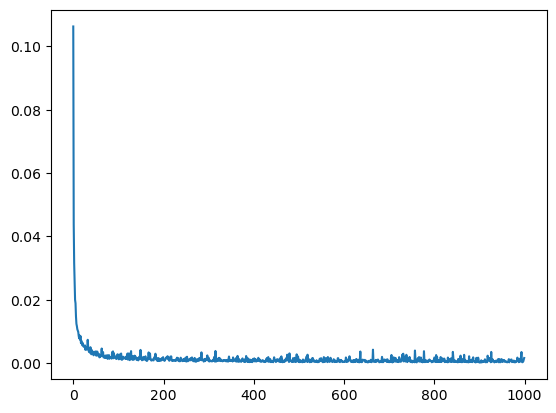

In [8]:
print("Accuracy on training set: {:.2f}%".format(nn.accuracy_score(X_train, y_train)*100))
print("Accuracy on validation set: {:.2f}%".format(nn.accuracy_score(X_valid, y_valid)*100))
print("Training time: {:.0f} sec".format(nn.train_time))
print("Loss: {:.4f}".format(loss[-1]))
plt.plot(loss)

### Multiclass classifier

In [9]:
class_1 = np.hstack([np.random.normal( 1, 1, size=(10000, 64)),  np.ones(shape=(10000, 1))])
class_2 = np.hstack([np.random.normal(-1, 1, size=(10000, 64)), np.zeros(shape=(10000, 1))])
class_3 = np.hstack([np.random.normal( 2, 1, size=(10000, 64)),  np.ones(shape=(10000, 1))+1])
class_4 = np.hstack([np.random.normal(-2, 1, size=(10000, 64)),  np.ones(shape=(10000, 1))+2])
dataset = np.vstack([class_1, class_2, class_3, class_4])
X = dataset[:, :-1]
y = dataset[:, -1].reshape(-1, 1)
X_train, y_train, X_valid, y_valid = train_validation_split(X, y, random_state=0)

In [10]:
layer1 = HiddenLayer(64, 32, activation='relu')
layer2 = HiddenLayer(32, 32, batch_norm=True)
layer3 = HiddenLayer(32, 16, activation='relu')
layer4 = HiddenLayer(16, 16, batch_norm=True)
layer5 = HiddenLayer(16, 8, activation='relu')
layer6 = HiddenLayer(8, 8, batch_norm=True)
layer7 = HiddenLayer(8, 4, activation='softmax')
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]
nn = MLP(layers, optimizer='adagrad',hyperparams={'learning_rate':0.001}, num_classes=4)
loss = nn.fit(X_train, y_train, epochs=1000, batch_size=32)

Accuracy on training set: 94.55%
Accuracy on validation set: 94.17%
Training time: 529 sec
Loss: 0.2601


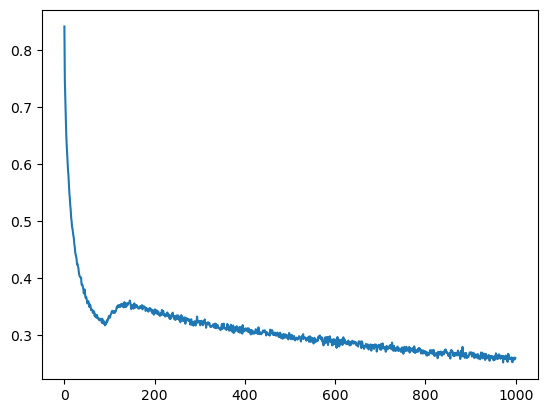

In [11]:
print("Accuracy on training set: {:.2f}%".format(nn.accuracy_score(X_train, y_train)*100))
print("Accuracy on validation set: {:.2f}%".format(nn.accuracy_score(X_valid, y_valid)*100))
print("Training time: {:.0f} sec".format(nn.train_time))
print("Loss: {:.4f}".format(loss[-1]))
plt.plot(loss)